In [1]:
import os
interface_dir = os.environ["DATA"] + "webinterfaces/int05_prototype/"

tasks_dir = os.path.join(interface_dir, "res", "tasks")

results_dir = os.path.join(interface_dir, "results")
protocols_dir = os.path.join(interface_dir, "protocols")

results_filenames_d = {
    "CF" : ["vgjml6bp.json"],
    "SHAP": ["9qs2oelz.json", "bora.json", "ggwmlvei.json"],
    "H": ["bkbcgvyd.json", "c5eblx4w.json", "lhrapnar.json", "rd1nxuhy.json", "tcq3r4vd.json"],
    # "AI": [],
}

protocol_paths_d = {
    "CF": os.path.join(protocols_dir, "XAI_CF_0.json"),
    "SHAP": os.path.join(protocols_dir, "XAI_SHAP_0.json"),
    "H": os.path.join(protocols_dir, "H_0.json"),
    "AI": os.path.join(protocols_dir, "AI_0.json"),
}

EASY_TASKS = ["med5_find_pattern", "med2_yellow_square_N", "med6_find_pattern", "med4_blue_triangle_N"]
DIFFICULT_TASKS = ["hard5_find_pattern", "hard2_blue_circle_N", "hard6_find_pattern", "hard4_yellow_square_N"]

MILD_PRESSURE_TASKS = ["med5_find_pattern", "med2_yellow_square_N", "hard5_find_pattern", "hard2_blue_circle_N"]
STRONG_PRESSURE_TASKS = ["med6_find_pattern", "med4_blue_triangle_N", "hard6_find_pattern", "hard4_yellow_square_N"]

FIND_PATTERNS_TASKS = ["med5_find_pattern", "med6_find_pattern", "hard5_find_pattern", "hard6_find_pattern"]
COUNT_SYMBOLS_TASKS = ["med2_yellow_square_N", "med4_blue_triangle_N", "hard2_blue_circle_N", "hard4_yellow_square_N"]


TASK_PROTOCOL_KEYS = {
    "med5_find_pattern": "mainexp_easy5_pat_task",
    "med2_yellow_square_N": "mainexp_easy2_N_task",
    "med6_find_pattern": "mainexp_easy6_pat_task",
    "med4_blue_triangle_N": "mainexp_easy4_N_task",

    "hard5_find_pattern": "mainexp_hard5_pat_task",
    "hard2_blue_circle_N": "mainexp_hard2_N_task",
    "hard6_find_pattern": "mainexp_hard6_pat_task",
    "hard4_yellow_square_N": "mainexp_hard4_N_task"
}



In [2]:
import sys
sys.path.append("/home/jleguy/Documents/postdoc/git_repos/WebXAII/")

In [3]:
import json
import csv
import numpy as np

def load_json(path):
    with open(path) as json_file:
        return json.load(json_file)

def load_task_csv_file(path):
    y_true, y_pred = [], []
    with open(path) as csv_data:
        reader = csv.DictReader(csv_data)
        for row in reader:
            y_true.append(int(row["target"]))
            y_pred.append(int(row["pred"]))

    return np.array(y_true), np.array(y_pred)


In [4]:
from pywebxaii.resretrieval import extract_p_task_results

def compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, tasks_names, task_protocol_keys):

    output_res_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)

            nb_questions = 0
            nb_correct = 0
            early_break = False

            # Iterating over all tasks
            for task_idx, task_name in enumerate(tasks_names):

                task_true, _ =  load_task_csv_file(os.path.join(tasks_dir, task_name + "_content.csv"))

                answers_idx_vect, answers_text_vect, _, _, _ = \
                    extract_p_task_results(load_json(curr_res_path),
                                           task_protocol_keys[tasks_names[task_idx]],
                                           protocol_d=load_json(protocol_paths_d[group_key]))

                nb_questions += len(answers_idx_vect)

                try:
                    nb_correct += np.sum(answers_idx_vect == np.logical_not(task_true))
                # Happens if the results file is not complete
                except ValueError:
                    output_res_d[group_key].append(None)
                    early_break = True
                    break

            if not early_break:
                output_res_d[group_key].append(nb_correct / nb_questions)

    return output_res_d


In [5]:
all_scores = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, EASY_TASKS+DIFFICULT_TASKS,
                            TASK_PROTOCOL_KEYS)

all_scores_easy = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, EASY_TASKS,
                            TASK_PROTOCOL_KEYS)

all_scores_difficult = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, DIFFICULT_TASKS,
                            TASK_PROTOCOL_KEYS)

all_scores_mild = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, MILD_PRESSURE_TASKS,
                            TASK_PROTOCOL_KEYS)

all_scores_strong = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, STRONG_PRESSURE_TASKS,
                            TASK_PROTOCOL_KEYS)

all_scores_findpatterns = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, FIND_PATTERNS_TASKS, TASK_PROTOCOL_KEYS)
all_scores_countsym = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, COUNT_SYMBOLS_TASKS, TASK_PROTOCOL_KEYS)

In [6]:
all_scores

{'CF': [0.6875],
 'SHAP': [0.7916666666666666, 0.8125, 0.75],
 'H': [0.7083333333333334,
  0.84375,
  0.7708333333333334,
  0.7916666666666666,
  0.84375]}

In [7]:
all_scores_easy

{'CF': [0.7708333333333334],
 'SHAP': [0.8958333333333334, 0.9166666666666666, 0.8541666666666666],
 'H': [0.75,
  0.9583333333333334,
  0.8541666666666666,
  0.8333333333333334,
  0.9166666666666666]}

In [8]:
all_scores_difficult

{'CF': [0.6041666666666666],
 'SHAP': [0.6875, 0.7083333333333334, 0.6458333333333334],
 'H': [0.6666666666666666,
  0.7291666666666666,
  0.6875,
  0.75,
  0.7708333333333334]}

In [29]:
data_scores_difficulty = {
    "easy tasks": all_scores_easy,
    "difficult tasks": all_scores_difficult,
}

data_scores_pressure = {
    "mild pressure tasks": all_scores_mild,
    "strong pressure tasks": all_scores_strong,
}

data_scores_tasks = {
    "find patterns tasks": all_scores_findpatterns,
    "count symbols tasks": all_scores_countsym,
}

In [10]:
import matplotlib.pyplot as plt

def scatter_groups(data, title="Group Scatter Plot", y_lim=None, y_line=None):
    """
    Make a scatter plot where:
      - x-axis is the group name
      - y-axis is the value
    Each group gets one color, and all points for that group share the same x.
    """
    plt.figure(figsize=(7, 4))

    for group, values in data.items():
        # Use the group name directly as the x position
        x_positions = [group] * len(values)
        plt.scatter(x_positions, values)

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    # plt.xlabel("Group")
    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    # plt.legend()
    plt.tight_layout()
    plt.show()

def scatter_groups_nested(data, title="Group Scatter Plot", y_lim=None, y_line=None):
    """
    Accepts data in the form:
    {
        "outerGroup1": {"innerA": [...], "innerB": [...], ...},
        "outerGroup2": {"innerA": [...], "innerB": [...], ...},
    }

    - Outer groups determine the color.
    - Inner groups determine the x-axis category.
    """
    plt.figure(figsize=(7, 4))

    # Determine all inner-group names (x-axis categories)
    inner_groups = list(next(iter(data.values())).keys())

    # Assign each outer group its own color
    cmap = plt.get_cmap("tab10")
    outer_group_names = list(data.keys())

    for i, outer in enumerate(outer_group_names):
        color = cmap(i % 10)  # safe cycling
        inner_dict = data[outer]

        # For each inner group, scatter its values at the correct x position
        for j, inner in enumerate(inner_groups):
            values = inner_dict[inner]
            x_positions = [inner] * len(values)
            plt.scatter(
                x_positions, values,
                color=color,
                label=f"{outer}" if j == 0 else None,
            )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    # plt.xlabel("Inner Group")
    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.legend(loc="lower right")   # bottom right
    plt.tight_layout()
    plt.show()

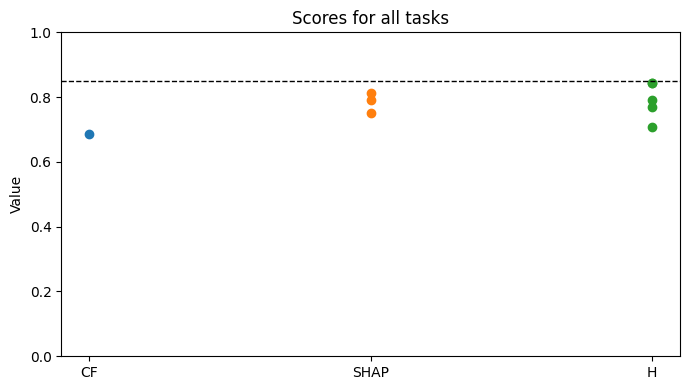

In [11]:
scatter_groups(all_scores, "Scores for all tasks", y_lim=(0, 1), y_line=0.85)


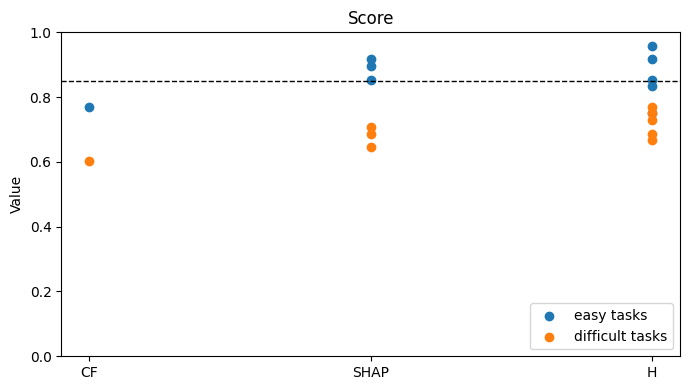

In [12]:
scatter_groups_nested(data_scores_difficulty, title="Score", y_lim=(0, 1), y_line=0.85)

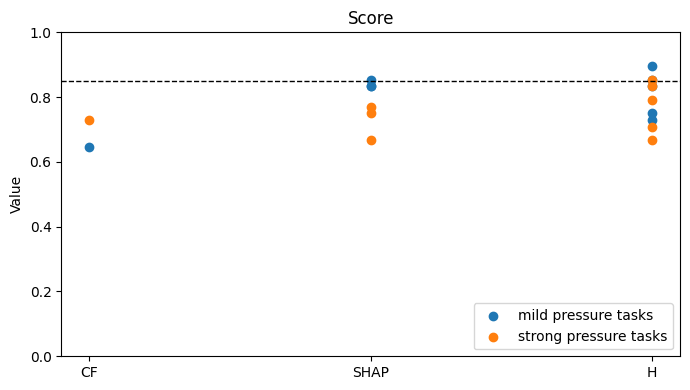

In [13]:
scatter_groups_nested(data_scores_pressure, title="Score", y_lim=(0, 1), y_line=0.85)

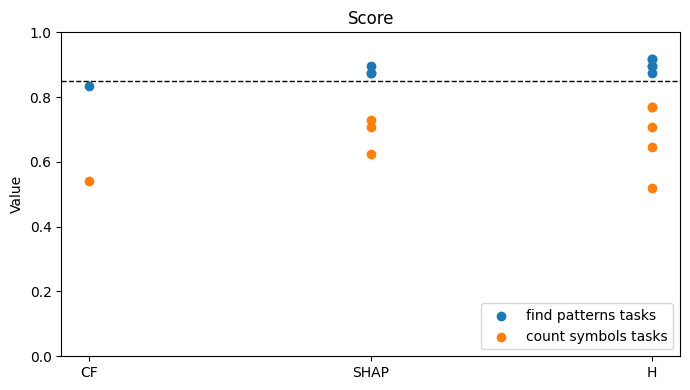

In [30]:
scatter_groups_nested(data_scores_tasks, title="Score", y_lim=(0, 1), y_line=0.85)

In [14]:
from pywebxaii.resretrieval import extract_total_times


def extract_times(results_dir, results_filenames_d):

    output_res_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)

            res_dict = load_json(curr_res_path)
            total_time, _ = extract_total_times(res_dict)

            output_res_d[group_key].append(total_time/60)

    return output_res_d


In [15]:
times_data = extract_times(results_dir, results_filenames_d)

In [16]:
times_data

{'CF': [29.733116666666668],
 'SHAP': [41.993233333333336, 41.341166666666666, 38.608716666666666],
 'H': [38.46868333333334,
  33.63203333333333,
  37.486,
  31.90195,
  34.397416666666665]}

In [17]:
alltimes = []
for k, v in times_data.items():
    alltimes.extend(v)
print({f"median : {np.median(alltimes)}"})

{'median : 37.486'}


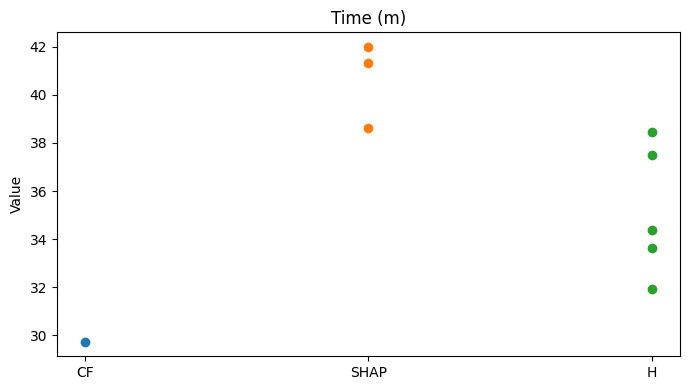

In [18]:
scatter_groups(times_data, "Time (m)")


In [19]:
from pywebxaii.resretrieval import extract_p_questionnaire_results


def extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys):

    output_res_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_d[group_key] = {"raw": {}, "values": {}, "times": {}}

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)

            # Iterating over all questionnaires keys
            for quest_key in quest_keys:

                answers_raw, answers_values, quest_times = extract_p_questionnaire_results(load_json(curr_res_path), quest_key,
                                                                                           protocol_d=load_json(protocol_paths_d[group_key]))
                if quest_key not in output_res_d[group_key]["raw"]:
                     output_res_d[group_key]["raw"][quest_key] = []
                     output_res_d[group_key]["values"][quest_key] = []
                     output_res_d[group_key]["times"][quest_key] = []

                output_res_d[group_key]["raw"][quest_key].append(answers_raw)
                output_res_d[group_key]["values"][quest_key].append(answers_values)
                output_res_d[group_key]["times"][quest_key].append(quest_times)

    return output_res_d

In [20]:
def process_cogload(cogload_results):
    output_d = {}
    for k, v in cogload_results.items():
        output_d[k] = {}
        for session_id, results_list in v["raw"].items():

            if session_id == "mainexp_easy_mild_cogload":
                session_name = "easy;mild"
            elif session_id == "mainexp_easy_strong_cogload":
                session_name = "easy;strong"
            elif session_id == "mainexp_hard_mild_cogload":
                session_name = "hard;mild"
            elif session_id == "mainexp_hard_strong_cogload":
                session_name = "hard;strong"

            if session_id not in output_d:
                output_d[k][session_name] = []
            for result_arr in results_list:
                output_d[k][session_name].append(np.sum(result_arr))

    return output_d


In [21]:
quest_keys = ["mainexp_easy_mild_cogload", "mainexp_easy_strong_cogload", "mainexp_hard_mild_cogload", "mainexp_hard_strong_cogload"]

cogload_results = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys)

In [22]:
cogload_results

{'CF': {'raw': {'mainexp_easy_mild_cogload': [array([5, 4, 5, 5, 5, 5], dtype=object)],
   'mainexp_easy_strong_cogload': [array([6, 4, 5, 4, 4, 6], dtype=object)],
   'mainexp_hard_mild_cogload': [array([5, 3, 3, 4, 3, 5], dtype=object)],
   'mainexp_hard_strong_cogload': [array([4, 4, 4, 4, 3, 5], dtype=object)]},
  'values': {'mainexp_easy_mild_cogload': [array(['', '', '', '', '', ''], dtype=object)],
   'mainexp_easy_strong_cogload': [array(['Very high', '', '', '', '', 'Very high'], dtype=object)],
   'mainexp_hard_mild_cogload': [array(['', '', '', '', '', ''], dtype=object)],
   'mainexp_hard_strong_cogload': [array(['', '', '', '', '', ''], dtype=object)]},
  'times': {'mainexp_easy_mild_cogload': [9690],
   'mainexp_easy_strong_cogload': [21296],
   'mainexp_hard_mild_cogload': [42600],
   'mainexp_hard_strong_cogload': [14280]}},
 'SHAP': {'raw': {'mainexp_easy_mild_cogload': [array([2, 0, 4, 1, 2, 3], dtype=object),
    array([3, 0, 1, 0, 2, 1], dtype=object),
    array([3,

In [23]:
cogload_processed = process_cogload(cogload_results)

In [24]:
cogload_processed

{'CF': {'easy;mild': [29],
  'easy;strong': [29],
  'hard;mild': [23],
  'hard;strong': [24]},
 'SHAP': {'easy;mild': [12, 7, 17],
  'easy;strong': [23, 24, 20],
  'hard;mild': [26, 19, 26],
  'hard;strong': [27, 28, 27]},
 'H': {'easy;mild': [13, 4, 15, 23, 6],
  'easy;strong': [30, 4, 21, 23, 19],
  'hard;mild': [30, 7, 21, 21, 11],
  'hard;strong': [32, 14, 25, 27, 27]}}

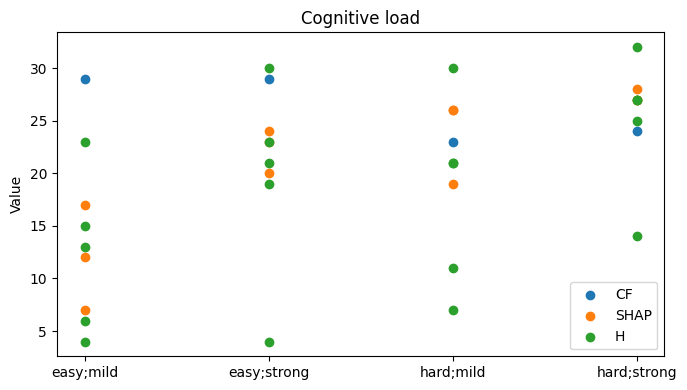

In [25]:
scatter_groups_nested(cogload_processed, title="Cognitive load")

In [26]:
quest_keys = ["mainexp_easy_mild_cogload", "mainexp_easy_strong_cogload", "mainexp_hard_mild_cogload", "mainexp_hard_strong_cogload"]

cogload_results = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys)

In [27]:
cogload_results

{'CF': {'raw': {'mainexp_easy_mild_cogload': [array([5, 4, 5, 5, 5, 5], dtype=object)],
   'mainexp_easy_strong_cogload': [array([6, 4, 5, 4, 4, 6], dtype=object)],
   'mainexp_hard_mild_cogload': [array([5, 3, 3, 4, 3, 5], dtype=object)],
   'mainexp_hard_strong_cogload': [array([4, 4, 4, 4, 3, 5], dtype=object)]},
  'values': {'mainexp_easy_mild_cogload': [array(['', '', '', '', '', ''], dtype=object)],
   'mainexp_easy_strong_cogload': [array(['Very high', '', '', '', '', 'Very high'], dtype=object)],
   'mainexp_hard_mild_cogload': [array(['', '', '', '', '', ''], dtype=object)],
   'mainexp_hard_strong_cogload': [array(['', '', '', '', '', ''], dtype=object)]},
  'times': {'mainexp_easy_mild_cogload': [9690],
   'mainexp_easy_strong_cogload': [21296],
   'mainexp_hard_mild_cogload': [42600],
   'mainexp_hard_strong_cogload': [14280]}},
 'SHAP': {'raw': {'mainexp_easy_mild_cogload': [array([2, 0, 4, 1, 2, 3], dtype=object),
    array([3, 0, 1, 0, 2, 1], dtype=object),
    array([3,

In [28]:
cogload_easy_mild_cf = [extract_p_questionnaire_results(load_json_file(os.path.join(results_dir, results_cf[i])),
                                                        "mainexp_easy_mild_cogload",
                                                        load_json_file(protocol_cf_path)) for i in range(len(results_cf))]

cogload_hard_strong_cf = [extract_p_questionnaire_results(load_json_file(os.path.join(results_dir, results_cf[i])),
                                                        "mainexp_hard_strong_cogload",
                                                        load_json_file(protocol_cf_path)) for i in range(len(results_cf))]

NameError: name 'results_cf' is not defined

In [ ]:
cogload_easy_mild_cf

In [ ]:
cogload_hard_strong_cf